In [1]:
from tensorflow.keras.layers import Lambda, Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
image_shape = x_train.shape[1:]

batch_size = 128
latent_dim = 64
epochs = 5

In [4]:
inputs = Input(shape=image_shape, name='encoder_input')
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [21]:
shape_before_flattening

(None, 8, 8, 64)

In [22]:
latent_dim

64

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [7]:
# Instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 4096)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [8]:
# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)


In [9]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 3)         867 

In [10]:
# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [11]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error

# VAE loss
# reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * image_shape[0] * image_shape[1]
reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs)) * image_shape[0] * image_shape[1]


kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [12]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 1101120   ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 decoder (Functional)        (None, 32, 32, 3)            322499    ['encoder[0][2]']             
                                                                                                

In [13]:
vae.fit(x_train,
        epochs=2,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/2
391/391 [==============================] - 34s 84ms/step - loss: 49.3071 - val_loss: 40.6410
Epoch 2/2
391/391 [==============================] - 33s 83ms/step - loss: 38.2137 - val_loss: 36.9645


In [14]:
xi = [0.8] * 64

In [15]:
z_sample = np.array([xi])

x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 94ms/step


In [16]:
x_decoded.shape

(1, 32, 32, 3)

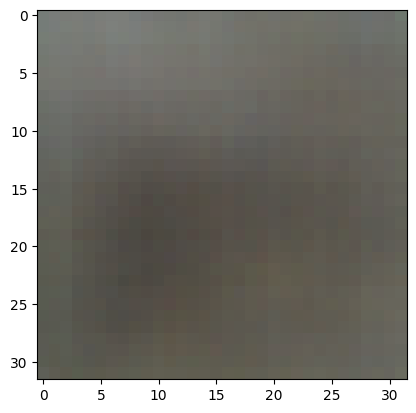

In [20]:
import matplotlib.pyplot as plt

plt.imshow(x_decoded[0])